In [75]:
# Setup
# Cell 1: Setup
import data_loader
import importlib
importlib.reload(data_loader)


# print(f"Box size1: {BOX_SIZE}")

# Setup
from data_loader import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

print("BOX_SIZE2:", BOX_SIZE)


plt.rcParams.update({'font.size': 14})

Loading bubble data...
✓ Loaded 634277 observations
✓ Timesteps added: 0 to 3426
✓ Identified 300 disappearing bubbles
Applying periodic boundary corrections...
✓ Periodic boundary correction applied
✓ Derived quantities computed

DATA LOADING COMPLETE
Total observations:       634,277
Unique bubbles:           400
Timesteps:                0 to 3426
Disappearing bubbles:     300
Box size:                 22.36068
Initial avg area (A_0):   1.000000

Available variables:
  - df: Original dataframe
  - df_corrected: Corrected dataframe with actual_area column
  - disappearing_ids: Set of disappearing bubble IDs
  - bubbles_per_timestep: Number of bubbles at each timestep
  - avg_area_per_timestep: Average bubble area at each timestep
  - approx_avg_area: Approximate area from liquid fraction
  - A_0: Initial average bubble area
  - max_timestep: Maximum timestep
  - final_step: Final timestep
  - box_area: Total box area
  - BOX_SIZE, PERIODIC_THRESHOLD, LIQUID_FRACTION: Constants

BOX_S

## FFT autocorrelation method

- Reference: *Econophysics and Physical Economics*, Sec. 2.1.3, eqs. (2.11)–(2.14) and Figs. 2.2–2.3 (definition of unnormalised covariance G(τ) and normalised R(τ)).
- FFT in plain terms: we compute the Discrete Fourier Transform fast (O(N log N)); the autocorrelation of a mean-subtracted series equals the inverse FFT of its power spectrum |FFT(x)|², which turns convolution into cheap elementwise multiplication.
- `scalar_acf_fft(x, max_lag)`: mean-centers x, zero-pads to avoid circular wrap, FFT → multiply by its complex conjugate to get |FFT(x)|² → inverse FFT to recover the linear autocovariance; divides each lag by the number of overlapping pairs (N, N−1, …) to get an unbiased per-lag average; returns C(τ) for τ ∈ [0, max_lag].
- `average_scalar_acf_over_bubbles(df, col, max_lag)`: runs `scalar_acf_fft` per bubble (grouped by `id`, sorted by timestep), sums and counts contributions per lag, and averages; also returns the normalised version C(τ)/C(0)=R(τ) (stationary-case normalisation in the book).
- `velocity_acf(df, max_lag)`: builds one-step velocities `vx, vy = diff(x), diff(y)`, computes their ACFs with `scalar_acf_fft`, averages over bubbles, and sums x/y components to get v·v; normalises by lag-0 variance.
- `position_acf(df, max_lag)`: same pattern but uses positions x, y directly to get r·r correlations.
- `area_acf` and `Z_acf`: thin wrappers to reuse the averaging helper for scalar columns `area` and `Z`.
- `correlation_time(lags, C_norm)`: discrete integral of the normalised ACF R(τ)=C(τ)/C(0), optionally stopping at first zero-crossing, giving τ_c in frame units.

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 1. Low-level helper: 1D autocorrelation via FFT
# ============================================================
def scalar_acf_fft(x, max_lag=None):
    """
    Compute autocorrelation of a 1D array x using FFT.
    Returns C[0:max_lag+1], unnormalised (C[0] = variance * N if mean-subtracted).
    """
    x = np.asarray(x, dtype=float)
    n = len(x)
    if max_lag is None or max_lag > n - 1:
        max_lag = n - 1

    # subtract mean to get covariance-like ACF
    x = x - np.mean(x)

    # zero-pad to avoid circular convolution wrap-around
    nfft = 1 << (2 * n - 1).bit_length()
    f = np.fft.rfft(x, n=nfft)
    # power spectrum
    p = f * np.conjugate(f)
    # inverse FFT to get correlation
    acf = np.fft.irfft(p, n=nfft)[:n]
    # normalise by number of terms contributing at each lag
    norm = np.arange(n, 0, -1, dtype=float)
    acf = acf / norm

    return acf[:max_lag + 1]  # from lag 0..max_lag


# ============================================================
# 2. Helper: average ACF over all bubbles for a given scalar column
# ============================================================
def average_scalar_acf_over_bubbles(df_corrected, col, max_lag):
    """
    Compute average autocorrelation function for a scalar column (e.g. area, Z)
    across all bubbles, up to max_lag.
    Returns:
        lags, C_avg (unnormalised), C_norm (C / C[0])
    """
    C_sum = np.zeros(max_lag + 1)
    counts = np.zeros(max_lag + 1)

    for bubble_id, g in df_corrected.groupby("id"):
        g = g.sort_values("timestep")
        x = g[col].to_numpy()
        if len(x) <= 1:
            continue

        C = scalar_acf_fft(x, max_lag=min(max_lag, len(x) - 1))
        this_lag_len = len(C)

        C_sum[:this_lag_len] += C
        counts[:this_lag_len] += 1

    valid = counts > 0
    C_avg = np.zeros_like(C_sum)
    C_avg[valid] = C_sum[valid] / counts[valid]

    # normalised ACF (C(τ)/C(0))
    C_norm = np.zeros_like(C_avg)
    if C_avg[0] != 0:
        C_norm[valid] = C_avg[valid] / C_avg[0]

    lags = np.arange(max_lag + 1)
    return lags, C_avg, C_norm

In [78]:
# ============================================================
# 3. Velocity autocorrelation C_v(τ)
# ============================================================
def velocity_acf(df_corrected, max_lag):
    """
    Compute velocity autocorrelation:
        C_v(τ) = < v(t)·v(t+τ) >
    where v is 1-step displacement: v = r(t+1) - r(t)
    Returns lags, C_v (unnormalised), C_v_norm.
    """
    Cx_sum = np.zeros(max_lag + 1)
    Cy_sum = np.zeros(max_lag + 1)
    counts = np.zeros(max_lag + 1)

    for bubble_id, g in df_corrected.groupby("id"):
        g = g.sort_values("timestep")
        x = g["x"].to_numpy()
        y = g["y"].to_numpy()

        # 1-step “velocity”
        vx = np.diff(x)
        vy = np.diff(y)

        if len(vx) < 2:  # need at least 2 points for non-zero lag
            continue

        Cx = scalar_acf_fft(vx, max_lag=min(max_lag, len(vx) - 1))
        Cy = scalar_acf_fft(vy, max_lag=min(max_lag, len(vy) - 1))
        this_lag_len = min(len(Cx), len(Cy))

        Cx_sum[:this_lag_len] += Cx[:this_lag_len]
        Cy_sum[:this_lag_len] += Cy[:this_lag_len]
        counts[:this_lag_len] += 1

    valid = counts > 0
    Cx_avg = np.zeros_like(Cx_sum)
    Cy_avg = np.zeros_like(Cy_sum)
    Cx_avg[valid] = Cx_sum[valid] / counts[valid]
    Cy_avg[valid] = Cy_sum[valid] / counts[valid]

    C_v = Cx_avg + Cy_avg  # v·v correlation = Cx + Cy

    C_v_norm = np.zeros_like(C_v)
    if C_v[0] != 0:
        C_v_norm[valid] = C_v[valid] / C_v[0]

    lags = np.arange(max_lag + 1)
    return lags, C_v, C_v_norm


# ============================================================
# 4. Position autocorrelation C_r(τ)
# ============================================================
def position_acf(df_corrected, max_lag):
    """
    Compute position autocorrelation:
        C_r(τ) = < r(t)·r(t+τ) >
    Returns lags, C_r (unnormalised), C_r_norm.
    """
    Cx_sum = np.zeros(max_lag + 1)
    Cy_sum = np.zeros(max_lag + 1)
    counts = np.zeros(max_lag + 1)

    for bubble_id, g in df_corrected.groupby("id"):
        g = g.sort_values("timestep")
        x = g["x"].to_numpy()
        y = g["y"].to_numpy()

        if len(x) < 2:
            continue

        Cx = scalar_acf_fft(x, max_lag=min(max_lag, len(x) - 1))
        Cy = scalar_acf_fft(y, max_lag=min(max_lag, len(y) - 1))
        this_lag_len = min(len(Cx), len(Cy))

        Cx_sum[:this_lag_len] += Cx[:this_lag_len]
        Cy_sum[:this_lag_len] += Cy[:this_lag_len]
        counts[:this_lag_len] += 1

    valid = counts > 0
    Cx_avg = np.zeros_like(Cx_sum)
    Cy_avg = np.zeros_like(Cy_sum)
    Cx_avg[valid] = Cx_sum[valid] / counts[valid]
    Cy_avg[valid] = Cy_sum[valid] / counts[valid]

    C_r = Cx_avg + Cy_avg

    C_r_norm = np.zeros_like(C_r)
    if C_r[0] != 0:
        C_r_norm[valid] = C_r[valid] / C_r[0]

    lags = np.arange(max_lag + 1)
    return lags, C_r, C_r_norm

In [79]:
# ============================================================
# 5. Area autocorrelation C_A(τ)
# ============================================================
def area_acf(df_corrected, max_lag):
    """
    Autocorrelation of bubble area (or radius, whatever is in df["area"]).
    Returns lags, C_A (unnormalised), C_A_norm.
    """
    return average_scalar_acf_over_bubbles(df_corrected, col="area", max_lag=max_lag)


# ============================================================
# 6. Coordination number autocorrelation C_Z(τ)
# ============================================================
def Z_acf(df_corrected, max_lag):
    """
    Autocorrelation of coordination number Z.
    Returns lags, C_Z (unnormalised), C_Z_norm.
    """
    return average_scalar_acf_over_bubbles(df_corrected, col="Z", max_lag=max_lag)

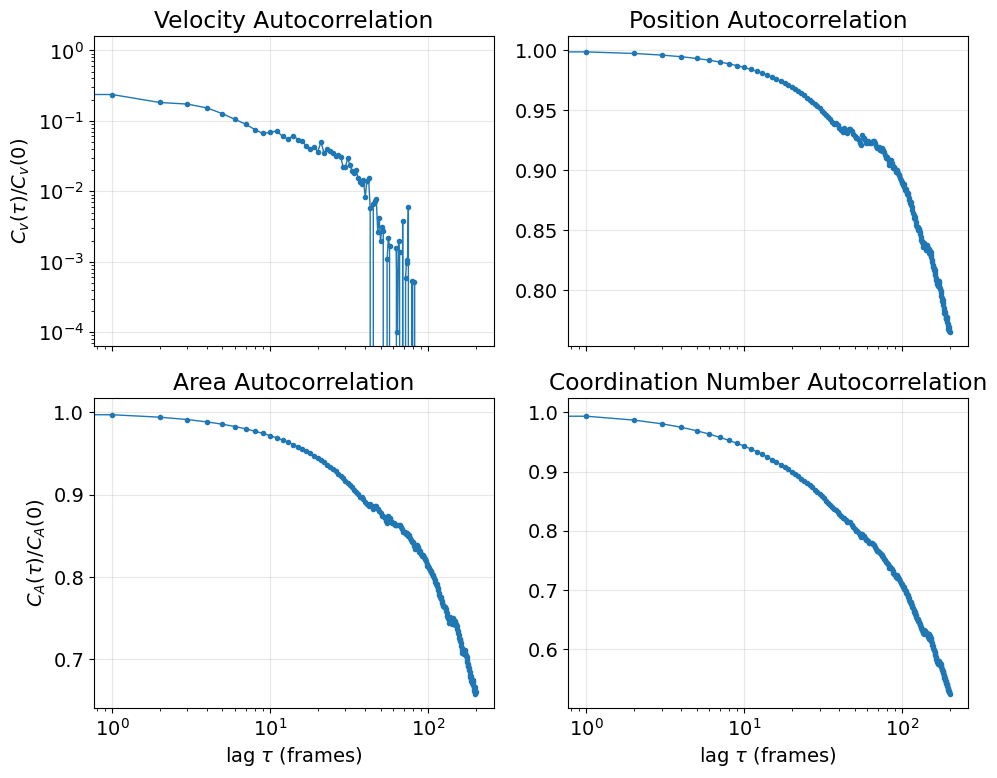

In [103]:
# ============================================================
# 7. Example: run everything & plot
# ============================================================

max_lag = 200  # you can tune this (in frames)

# --- compute ACFs ---
lags_v, C_v, C_v_norm = velocity_acf(df_corrected, max_lag=max_lag)
lags_r, C_r, C_r_norm = position_acf(df_corrected, max_lag=max_lag)
lags_A, C_A, C_A_norm = area_acf(df_corrected, max_lag=max_lag)
lags_Z, C_Z, C_Z_norm = Z_acf(df_corrected, max_lag=max_lag)

# --- plotting: 4-panel figure of normalised ACFs ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
(ax1, ax2), (ax3, ax4) = axes

# Velocity ACF
ax1.loglog(lags_v, C_v_norm, marker='o', ms=3, lw=1)
ax1.set_title("Velocity Autocorrelation")
ax1.set_ylabel(r"$C_v(\tau)/C_v(0)$")
ax1.grid(alpha=0.3)

# Position ACF
ax2.plot(lags_r, C_r_norm, marker='o', ms=3, lw=1)
ax2.set_title("Position Autocorrelation")
ax2.grid(alpha=0.3)

# Area ACF
ax3.plot(lags_A, C_A_norm, marker='o', ms=3, lw=1)
ax3.set_title("Area Autocorrelation")
ax3.set_xlabel(r"lag $\tau$ (frames)")
ax3.set_ylabel(r"$C_A(\tau)/C_A(0)$")
ax3.grid(alpha=0.3)

# Z ACF
ax4.plot(lags_Z, C_Z_norm, marker='o', ms=3, lw=1)
ax4.set_title("Coordination Number Autocorrelation")
ax4.set_xlabel(r"lag $\tau$ (frames)")
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [81]:
def correlation_time(lags, C_norm, stop_at_zero_cross=True):
    """
    Estimate correlation time τ_c from a normalised ACF C_norm(τ).
    
    Parameters
    ----------
    lags : array-like
        Lag values (integer timesteps).
    C_norm : array-like
        Normalised autocorrelation C(τ)/C(0).
    stop_at_zero_cross : bool
        If True, stop summing at the first lag where the ACF
        becomes non-positive (≤ 0).
    
    Returns
    -------
    tau_c : float
        Estimated correlation time in units of timesteps.
    """
    lags = np.asarray(lags)
    C_norm = np.asarray(C_norm)

    if stop_at_zero_cross:
        # find first index where ACF ≤ 0 (after lag 0)
        mask = np.where(C_norm[1:] <= 0)[0]
        if len(mask) > 0:
            cut_index = mask[0] + 1  # +1 offset because we started from index 1
        else:
            cut_index = len(C_norm)
    else:
        cut_index = len(C_norm)

    # sum from τ=0 to τ=cut_index-1
    tau_c = np.sum(C_norm[:cut_index])  # Δt = 1 per frame

    return tau_c

In [82]:
tau_c_v  = correlation_time(lags_v, C_v_norm)
tau_c_r  = correlation_time(lags_r, C_r_norm)
tau_c_A  = correlation_time(lags_A, C_A_norm)
tau_c_Z  = correlation_time(lags_Z, C_Z_norm)

print(f"Velocity correlation time τ_c^v  ≈ {tau_c_v:.1f} frames")
print(f"Position correlation time τ_c^r  ≈ {tau_c_r:.1f} frames")
print(f"Area correlation time τ_c^A      ≈ {tau_c_A:.1f} frames")
print(f"Z correlation time τ_c^Z         ≈ {tau_c_Z:.1f} frames")

Velocity correlation time τ_c^v  ≈ 3.3 frames
Position correlation time τ_c^r  ≈ 177.3 frames
Area correlation time τ_c^A      ≈ 163.3 frames
Z correlation time τ_c^Z         ≈ 144.2 frames


In [83]:
# ============================================================
# Split df_corrected into early and late based on timestep
# ============================================================
all_timesteps = df_corrected["timestep"].to_numpy()
t_med = np.median(all_timesteps)

df_early = df_corrected[df_corrected["timestep"] <= t_med].copy()
df_late  = df_corrected[df_corrected["timestep"] >  t_med].copy()

print("Median timestep:", t_med)
print("Early timesteps:  min =", df_early["timestep"].min(), 
      "max =", df_early["timestep"].max())
print("Late timesteps:   min =", df_late["timestep"].min(), 
      "max =", df_late["timestep"].max())

Median timestep: 1143.0
Early timesteps:  min = 0 max = 1143
Late timesteps:   min = 1144 max = 3426


[Velocity] τ_c early ≈ 3.3 frames
[Velocity] τ_c late  ≈ 3.2 frames


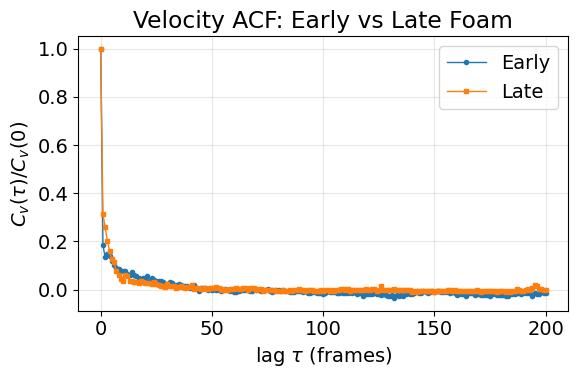

In [84]:
max_lag = 200  # you can adjust if needed

# Velocity ACF for early and late
lags_v_e, C_v_e, C_v_e_norm = velocity_acf(df_early, max_lag=max_lag)
lags_v_l, C_v_l, C_v_l_norm = velocity_acf(df_late,  max_lag=max_lag)

# Correlation times
tau_c_v_e = correlation_time(lags_v_e, C_v_e_norm)
tau_c_v_l = correlation_time(lags_v_l, C_v_l_norm)

print(f"[Velocity] τ_c early ≈ {tau_c_v_e:.1f} frames")
print(f"[Velocity] τ_c late  ≈ {tau_c_v_l:.1f} frames")

# Plot
plt.figure(figsize=(6,4))
plt.plot(lags_v_e, C_v_e_norm, marker='o', ms=3, lw=1, label='Early')
plt.plot(lags_v_l, C_v_l_norm, marker='s', ms=3, lw=1, label='Late')
plt.xlabel(r"lag $\tau$ (frames)")
plt.ylabel(r"$C_v(\tau)/C_v(0)$")
plt.title("Velocity ACF: Early vs Late Foam")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

[Area] τ_c early ≈ 112.6 frames
[Area] τ_c late  ≈ 155.8 frames


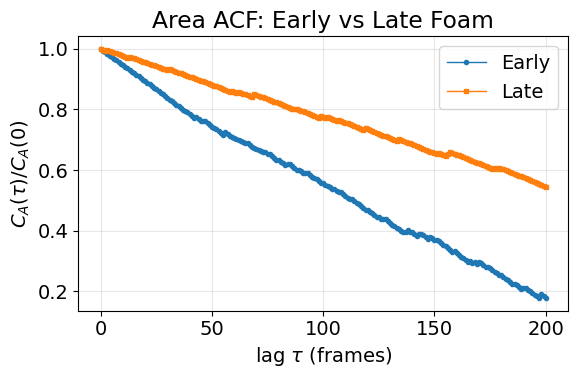

In [85]:
# Area ACF for early and late
lags_A_e, C_A_e, C_A_e_norm = area_acf(df_early, max_lag=max_lag)
lags_A_l, C_A_l, C_A_l_norm = area_acf(df_late,  max_lag=max_lag)

tau_c_A_e = correlation_time(lags_A_e, C_A_e_norm)
tau_c_A_l = correlation_time(lags_A_l, C_A_l_norm)

print(f"[Area] τ_c early ≈ {tau_c_A_e:.1f} frames")
print(f"[Area] τ_c late  ≈ {tau_c_A_l:.1f} frames")

plt.figure(figsize=(6,4))
plt.plot(lags_A_e, C_A_e_norm, marker='o', ms=3, lw=1, label='Early')
plt.plot(lags_A_l, C_A_l_norm, marker='s', ms=3, lw=1, label='Late')
plt.xlabel(r"lag $\tau$ (frames)")
plt.ylabel(r"$C_A(\tau)/C_A(0)$")
plt.title("Area ACF: Early vs Late Foam")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

[Z] τ_c early ≈ 101.1 frames
[Z] τ_c late  ≈ 137.1 frames


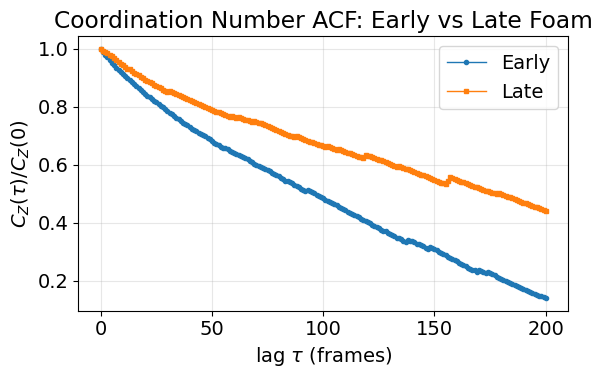

In [86]:
# Z ACF for early and late
lags_Z_e, C_Z_e, C_Z_e_norm = Z_acf(df_early, max_lag=max_lag)
lags_Z_l, C_Z_l, C_Z_l_norm = Z_acf(df_late,  max_lag=max_lag)

tau_c_Z_e = correlation_time(lags_Z_e, C_Z_e_norm)
tau_c_Z_l = correlation_time(lags_Z_l, C_Z_l_norm)

print(f"[Z] τ_c early ≈ {tau_c_Z_e:.1f} frames")
print(f"[Z] τ_c late  ≈ {tau_c_Z_l:.1f} frames")

plt.figure(figsize=(6,4))
plt.plot(lags_Z_e, C_Z_e_norm, marker='o', ms=3, lw=1, label='Early')
plt.plot(lags_Z_l, C_Z_l_norm, marker='s', ms=3, lw=1, label='Late')
plt.xlabel(r"lag $\tau$ (frames)")
plt.ylabel(r"$C_Z(\tau)/C_Z(0)$")
plt.title("Coordination Number ACF: Early vs Late Foam")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

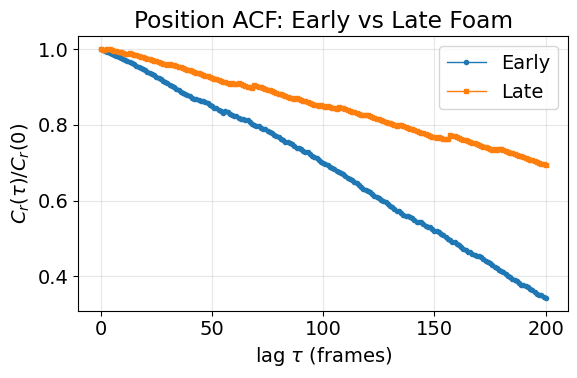

In [87]:
lags_r_e, C_r_e, C_r_e_norm = position_acf(df_early, max_lag=max_lag)
lags_r_l, C_r_l, C_r_l_norm = position_acf(df_late,  max_lag=max_lag)

plt.figure(figsize=(6,4))
plt.plot(lags_r_e, C_r_e_norm, marker='o', ms=3, lw=1, label='Early')
plt.plot(lags_r_l, C_r_l_norm, marker='s', ms=3, lw=1, label='Late')
plt.xlabel(r"lag $\tau$ (frames)")
plt.ylabel(r"$C_r(\tau)/C_r(0)$")
plt.title("Position ACF: Early vs Late Foam")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

FFT vs explicit unnormalised close? True
FFT vs explicit normalised close?   True


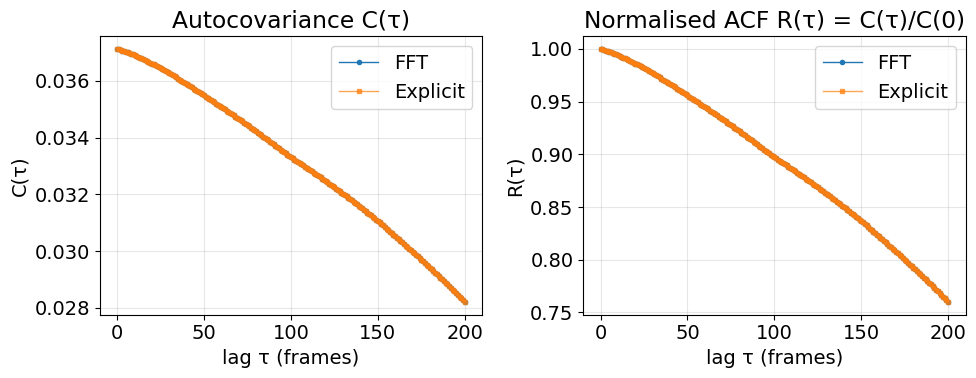

In [91]:
# ============================================================
# Explicit autocorrelation (book eq. 2.11 / 2.12) 
# ============================================================

def scalar_acf_explicit(x, max_lag):
    """
    Directly compute C(tau) = <(x(t)-<x>)(x(t+tau)-<x>)> with a sliding sum,
    dividing by (N-tau) per the book's time-average definition.
    Returns lags, C (unnormalised), and C_norm = C/C[0].
    """
    x = np.asarray(x, dtype=float) # ensure numpy array
    n = len(x)
    if n == 0:
        return np.array([]), np.array([]), np.array([]) # empty input
    max_lag = min(max_lag, n - 1) 
    mu = np.mean(x) # mean
    C = np.empty(max_lag + 1) # preallocate
    for tau in range(max_lag + 1):
        count = n - tau # number of terms contributing
        if count <= 0: # no terms
            C[tau] = np.nan
            continue
        C[tau] = np.sum((x[:count] - mu) * (x[tau:tau + count] - mu)) / count # sliding sum
    C_norm = C / C[0] if C[0] != 0 else C
    lags = np.arange(max_lag + 1) # build lags
    return lags, C, C_norm

# Choose one bubble and compare FFT vs explicit
max_lag = 200
first_id = df_corrected['id'].iloc[0]
series = df_corrected[df_corrected['id'] == first_id].sort_values('timestep')['x'].to_numpy()
max_lag_use = min(max_lag, len(series) - 1)

# FFT-based ACF (returns only C), build lags and normalisation
C_fft = scalar_acf_fft(series, max_lag=max_lag_use)
lags_fft = np.arange(len(C_fft))
C_fft_norm = C_fft / C_fft[0] if C_fft[0] != 0 else C_fft

# Explicit ACF
lags_exp, C_exp, C_exp_norm = scalar_acf_explicit(series, max_lag=max_lag_use)

print("FFT vs explicit unnormalised close?", np.allclose(C_fft, C_exp, atol=1e-10))
print("FFT vs explicit normalised close?  ", np.allclose(C_fft_norm, C_exp_norm, atol=1e-10))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(lags_fft, C_fft, label='FFT', marker='o', ms=3, lw=1)
axes[0].plot(lags_exp, C_exp, label='Explicit', marker='s', ms=3, lw=1, alpha=0.7)
axes[0].set_title('Autocovariance C(τ)')
axes[0].set_xlabel('lag τ (frames)')
axes[0].set_ylabel('C(τ)')
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(lags_fft, C_fft_norm, label='FFT', marker='o', ms=3, lw=1)
axes[1].plot(lags_exp, C_exp_norm, label='Explicit', marker='s', ms=3, lw=1, alpha=0.7)
axes[1].set_title('Normalised ACF R(τ) = C(τ)/C(0)')
axes[1].set_xlabel('lag τ (frames)')
axes[1].set_ylabel('R(τ)')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


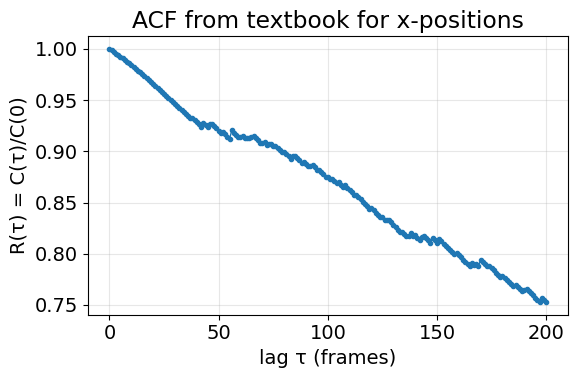

In [101]:
# Sliding-sum autocorrelation across all bubbles (textbook discrete form)

def average_explicit_acf_over_bubbles(df, col, max_lag):
    C_sum = np.zeros(max_lag + 1)
    counts = np.zeros(max_lag + 1)
    for _, g in df.groupby("id"):
        g = g.sort_values("timestep")
        x = g[col].to_numpy()
        if len(x) < 2:
            continue
        lags, C, _ = scalar_acf_explicit(x, max_lag=min(max_lag, len(x) - 1))
        this_len = len(C)
        C_sum[:this_len] += C
        counts[:this_len] += 1
    valid = counts > 0
    C_avg = np.zeros_like(C_sum)
    C_avg[valid] = C_sum[valid] / counts[valid]
    C_norm = np.zeros_like(C_avg)
    if C_avg[0] != 0:
        C_norm[valid] = C_avg[valid] / C_avg[0]
    lags = np.arange(max_lag + 1)
    return lags, C_avg, C_norm

# Example: x-position ACF across all bubbles
max_lag = 200
lags_x, C_x, C_x_norm = average_explicit_acf_over_bubbles(df_corrected, col="x", max_lag=max_lag)

plt.figure(figsize=(6, 4))
plt.plot(lags_x, C_x_norm, marker='o', ms=3, lw=1)
plt.title(f"ACF from textbook for x-positions")
plt.xlabel("lag τ (frames)")
plt.ylabel("R(τ) = C(τ)/C(0)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


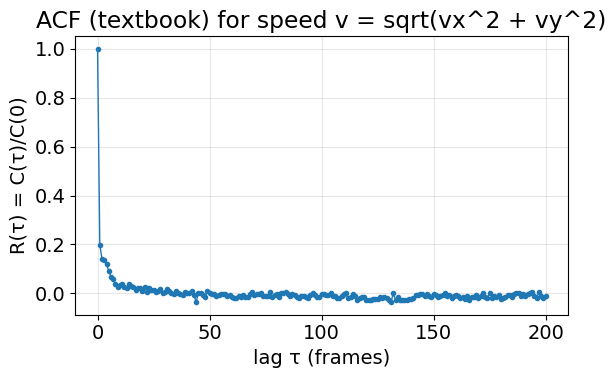

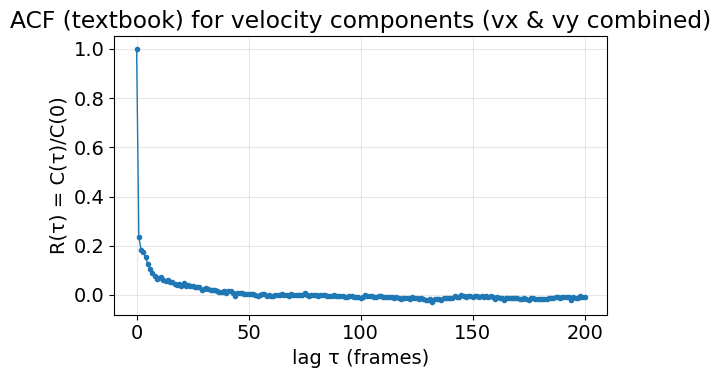

In [ ]:
def make_velocity_df(df, xcol="x", ycol="y", tcol="timestep", idcol="id"):
    """
    Returns a dataframe with per-bubble velocities:
      vx = x[t]-x[t-1]
      vy = y[t]-y[t-1]
      v  = sqrt(vx^2 + vy^2)

    Assumes constant frame spacing (dt=1 frame). If you have irregular timesteps,
    you can divide by np.diff(t) inside each group.
    """
    rows = []
    for bid, g in df.groupby(idcol):
        g = g.sort_values(tcol)
        x = g[xcol].to_numpy()
        y = g[ycol].to_numpy()
        t = g[tcol].to_numpy()

        if len(x) < 2:
            continue

        dx = np.diff(x)
        dy = np.diff(y)

        # If timesteps are not strictly consecutive, use:
        # dt = np.diff(t)
        # dx = dx / dt
        # dy = dy / dt

        vx = dx
        vy = dy
        v  = np.sqrt(vx**2 + vy**2)

        # velocity values live "between" frames; attach to the later timestep
        t_out = t[1:]

        rows.append(pd.DataFrame({
            idcol: bid,
            tcol: t_out,
            "vx": vx,
            "vy": vy,
            "v":  v
        }))

    if not rows:
        return pd.DataFrame(columns=[idcol, tcol, "vx", "vy", "v"])
    return pd.concat(rows, ignore_index=True)


def average_explicit_acf_over_bubbles(df, col, max_lag):
    C_sum = np.zeros(max_lag + 1)
    counts = np.zeros(max_lag + 1)

    for _, g in df.groupby("id"):
        g = g.sort_values("timestep")
        x = g[col].to_numpy()
        if len(x) < 2:
            continue

        lags, C, _ = scalar_acf_explicit(x, max_lag=min(max_lag, len(x) - 1))
        this_len = len(C)

        C_sum[:this_len] += C
        counts[:this_len] += 1

    valid = counts > 0
    C_avg = np.zeros_like(C_sum)
    C_avg[valid] = C_sum[valid] / counts[valid]

    C_norm = np.zeros_like(C_avg)
    if C_avg[0] != 0:
        C_norm[valid] = C_avg[valid] / C_avg[0]

    lags = np.arange(max_lag + 1)
    return lags, C_avg, C_norm


def average_acf_for_vx_vy_combined(df_vel, max_lag):
    """
    "Double the dataset" idea: treat vx and vy as equally valid samples.
    Best practice: average unnormalized C(τ) first, then normalize once.
    """
    lags, Cvx, _ = average_explicit_acf_over_bubbles(df_vel, col="vx", max_lag=max_lag)
    _,    Cvy, _ = average_explicit_acf_over_bubbles(df_vel, col="vy", max_lag=max_lag)

    C_avg = 0.5 * (Cvx + Cvy)

    C_norm = np.zeros_like(C_avg)
    if C_avg[0] != 0:
        C_norm = C_avg / C_avg[0]

    return lags, C_avg, C_norm


# ---- Usage ----
max_lag = 200

df_vel = make_velocity_df(df_corrected, xcol="x", ycol="y", tcol="timestep", idcol="id")

# (A) ACF of speed (radial velocity magnitude)
lags_v, C_v, C_v_norm = average_explicit_acf_over_bubbles(df_vel, col="v", max_lag=max_lag)

plt.figure(figsize=(6, 4))
plt.plot(lags_v, C_v_norm, marker='o', ms=3, lw=1)
plt.title("ACF for speed v = sqrt(vx^2 + vy^2)")
plt.xlabel("lag τ (frames)")
plt.ylabel("R(τ) = C(τ)/C(0)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# (B) Combined-component ACF (vx + vy treated as doubled dataset)
lags_c, C_c, C_c_norm = average_acf_for_vx_vy_combined(df_vel, max_lag=max_lag)

plt.figure(figsize=(6, 4))
plt.plot(lags_c, C_c_norm, marker='o', ms=3, lw=1)
plt.title("ACF for velocity components (vx & vy combined)")
plt.xlabel("lag τ (frames)")
plt.ylabel("R(τ) = C(τ)/C(0)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

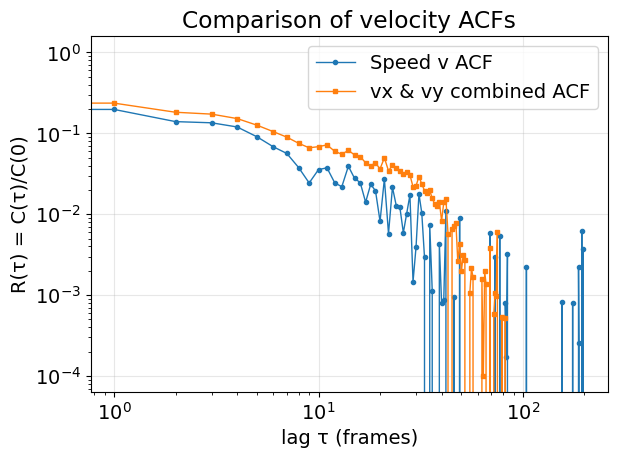

In [105]:
plt.loglog(lags_v, C_v_norm, marker='o', ms=3, lw=1, label='Speed v ACF')
plt.loglog(lags_c, C_c_norm, marker='s', ms=3, lw=1, label='vx & vy combined ACF')
plt.title("Comparison of velocity ACFs")
plt.xlabel("lag τ (frames)")
plt.ylabel("R(τ) = C(τ)/C(0)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()